Commands specific to Google Colab. If running on colab, please use a L4 GPU or T4 GPU with high RAM.

We access the COMRECGC repository through a saved copy on Google Drive. That copy is synchronized with git via the Drive and Git desktop application.

In [3]:
%%capture
!pip install torch_geometric
!pip install torch
!python3 --version

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/COMRECGC-main

/content/drive/MyDrive/COMRECGC-main


To generate COMRECGC's solution to the FCR and FC problem, please run the whole notebook beyond this cell.

In [4]:
import os
import torch
import torch_geometric.utils as torch_utils
import networkx as nx
import random
import matplotlib.pyplot as plt
import pickle
from numba import cuda
from torch.masked import masked_tensor, as_masked_tensor
from tqdm import tqdm
import argparse
import os.path
import torch
import numpy as np
import torch_geometric as tg
from torch_geometric.data import Data, Batch, DataLoader
from torch_geometric.transforms import RemoveIsolatedNodes, ToUndirected
from torch_geometric.utils.convert import to_networkx, from_networkx
import copy
from sklearn import metrics
from sklearn.cluster import DBSCAN, HDBSCAN

In [5]:
import util
import distance
from data import load_dataset # loads datasets
from gnn import load_trained_gnn, load_trained_prediction # loads input graphs, loads trained gnn

# 1: Set up - utils - Just run the following section




In [15]:
def prepare_devices(device1, device2):
    device1 = 'cuda:' + device1 if torch.cuda.is_available() and device1 in ['0', '1', '2', '3'] else 'cpu'
    device2 = 'cuda:' + device2 if torch.cuda.is_available() and device2 in ['0', '1', '2', '3'] else 'cpu'

    return device1, device2

In [16]:
def get_args():
    parser = argparse.ArgumentParser(description='Graph Global Counterfactual Summary')
    parser.add_argument('--dataset', type=str, default='mutagenicity', choices=['mutagenicity', 'aids', 'nci1', 'proteins'])
    parser.add_argument('--alpha', type=float, default=0.5, help='alpha value to balance individual and cumulative coverage')
    parser.add_argument('--theta', type=float, default=0.05, help='distance threshold value during training.')
    parser.add_argument('--teleport', type=float, default=0.1, help='teleport probability to input graphs')
    parser.add_argument('--max_steps', type=int, default=50000, help='random walk step size')
    parser.add_argument('--k', type=int, default=100000, help='number of graphs will be selected from counterfactuals')
    parser.add_argument('--device1', type=str, help='Cuda device or cpu for gnn model', default='0')
    parser.add_argument('--device2', type=str, help='Cuda device or cpu for neurosed model', default='0')
    parser.add_argument('--sample_size', type=int, help='Sample count for neighbour graphs', default=10000)
    parser.add_argument('--sample', action='store_true')
    return parser.parse_args()


def calculate_hash(graph_embedding):
    if isinstance(graph_embedding, (np.ndarray,)):
        return hash(graph_embedding.tobytes())
    else:
        raise Exception('graph_embedding should be ndarray')


def node_label_change(graph):
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for i in range(graph.x.shape[0]):
        for j in range(graph.x.shape[1]):
            # if graph['node_labels'][i] != j:
            if graph.x[i, j] != 1:
                neighbor_graph_action = ('NLC', i, j)
                neighbor_graphs_actions.append(neighbor_graph_action)
                neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def node_addition(graph):
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for i in range(graph.x.shape[0]):
        for j in range(graph.x.shape[1]):  # Add a new node with label j connected with node i.
            neighbor_graph_action = ('NA', i, j)
            neighbor_graphs_actions.append(neighbor_graph_action)
            neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def isolated_node_addition(graph):
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for j in range(graph.x.shape[1]):  # Add a new isolated node with label j
        neighbor_graph_action = ('INA', j, j)
        neighbor_graphs_actions.append(neighbor_graph_action)
        neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def node_removal(graph):
    degree = torch_utils.degree(graph.edge_index[0], num_nodes=graph.num_nodes)
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for i in range(len(degree)):
        if degree[i] == 1:  # Remove nodes with exactly one edge only.
            neighbor_graph_action = ('NR', i, i)
            neighbor_graphs_actions.append(neighbor_graph_action)
            neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def isolated_node_removal(graph):
    degree = torch_utils.degree(graph.edge_index[0], num_nodes=graph.num_nodes)
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for i in range(len(degree)):
        if degree[i] == 0:  # Remove isolated nodes only.
            neighbor_graph_action = ('INR', i, i)
            neighbor_graphs_actions.append(neighbor_graph_action)
            neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def edge_change(graph, keep_bridge=True, only_removal=False):
    nxg = torch_utils.to_networkx(graph, to_undirected=True)  # 157 µs ± 71.9 µs per loop
    bridges = set(nx.bridges(nxg)) if keep_bridge else set()  # 556 µs ± 31.2 µs per loop
    num_nodes = graph.x.shape[0]
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if nxg.has_edge(i, j):
                if keep_bridge and (i, j) not in bridges:  # edge exist and its removal does not disconnect the graph
                    neighbor_graph_action = ('ER', i, j)
                else:  # remove edge regardlessly
                    neighbor_graph_action = ('ERR', i, j)
                neighbor_graphs_actions.append(neighbor_graph_action)
                neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
            elif not nxg.has_edge(i, j) and not only_removal:  # add edges
                neighbor_graph_action = ('EA', i, j)
                neighbor_graphs_actions.append(neighbor_graph_action)
                neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def neighbor_graph_access(graph, neighbor_graph_action):
    neighbor_graph = graph.clone()
    action = neighbor_graph_action[0]
    if action == 'NOTHING':
        neighbor_graph = neighbor_graph
    elif action == 'NLC':  # node label change
        _, i, j = neighbor_graph_action
        neighbor_graph.x[i] = 0  # 6.93 µs ± 301 ns per loop
        neighbor_graph.x[i][j] = 1  # 7.9 µs ± 420 ns per loop
    elif action == 'NA':  # node addition
        _, i, j = neighbor_graph_action
        neighbor_graph.num_nodes += 1
        neighbor_graph.edge_index = torch.hstack([graph.edge_index, torch.tensor([[i, graph.num_nodes], [graph.num_nodes, i]])])  # 14.1 µs ± 57.3 ns per loop, 3 times faster than padder.
        neighbor_graph.x = torch.vstack([graph.x, torch.nn.functional.one_hot(torch.tensor(j), graph.x.shape[1])])  # 36.8 µs ± 340 ns per loop, similar to padder.
    elif action == 'INA':  # isolated node addition.
        _, i, j = neighbor_graph_action
        neighbor_graph.num_nodes += 1
        neighbor_graph.x = torch.vstack([graph.x, torch.nn.functional.one_hot(torch.tensor(j), graph.x.shape[1])])  # 36.8 µs ± 340 ns per loop, similar to padder.
    elif action in ('NR', 'INR'):  # (isolated) node removal
        _, i, j = neighbor_graph_action
        indices = torch.LongTensor(list(range(i)) + list(range(i + 1, graph.num_nodes)))  # 4.93 µs ± 244 ns per loop
        neighbor_graph.num_nodes -= 1
        neighbor_graph.edge_index = torch_utils.subgraph(indices, graph.edge_index, relabel_nodes=True, num_nodes=graph.num_nodes)[0]  # 80.5 µs ± 992 ns per loop
        neighbor_graph.x = neighbor_graph.x[indices]  # 7.44 µs ± 149 ns per loop
    elif action in ('ER', 'ERR'):  # edge removal (regardlessly)
        _, i, j = neighbor_graph_action
        neighbor_graph.edge_index = graph.edge_index[:, ~((graph.edge_index[0] == i) & (graph.edge_index[1] == j) | (graph.edge_index[0] == j) & (graph.edge_index[1] == i))]  # 78.9 µs ± 1.87 µs per loop
    elif action == 'EA':  # edge addition
        _, i, j = neighbor_graph_action
        neighbor_graph.edge_index = torch.hstack([graph.edge_index, torch.tensor([[i, j], [j, i]])])  # 14 µs ± 262 ns per loop
    else:
        raise NotImplementedError(f'Neighbor edit action {action} not supported. ')
    return neighbor_graph


def is_counterfactual_array_full():
    return len(counterfactual_candidates) >= MAX_COUNTERFACTUAL_SIZE


def get_minimum_frequency():
    return counterfactual_candidates[-1]['frequency']


def is_graph_counterfactual(graph_hash):
    return counterfactual_candidates[graph_index_map[graph_hash]]['importance_parts'][0] >= 0.5


def reorder_counterfactual_candidates(start_idx):
    swap_idx = start_idx - 1
    while swap_idx >= 0 and counterfactual_candidates[start_idx]['frequency'] > counterfactual_candidates[swap_idx]['frequency']:
        swap_idx -= 1
    swap_idx += 1
    if swap_idx < start_idx:
        graph_index_map[counterfactual_candidates[start_idx]['graph_hash']] = swap_idx
        graph_index_map[counterfactual_candidates[swap_idx]['graph_hash']] = start_idx
        counterfactual_candidates[start_idx], counterfactual_candidates[swap_idx] = counterfactual_candidates[swap_idx], counterfactual_candidates[start_idx]
    return swap_idx


def update_input_graphs_covered(add_graph_covering_list=None, remove_graph_covering_list=None):
    global input_graphs_covered
    if add_graph_covering_list is not None:
        input_graphs_covered += add_graph_covering_list
    if remove_graph_covering_list is not None:
        input_graphs_covered -= remove_graph_covering_list


def check_reinforcement_condition(graph_hash):
    return is_graph_counterfactual(graph_hash)


def populate_counterfactual_candidates(graph_hash, importance_parts, input_graphs_covering_list = None, bypass_size = False):
    is_new_graph = False
    if graph_hash in graph_index_map:
        graph_idx = graph_index_map[graph_hash]
        condition = check_reinforcement_condition(graph_hash)
        if condition:
            counterfactual_candidates[graph_idx]['frequency'] += 1
            swap_idx = reorder_counterfactual_candidates(graph_idx)
        else:
            swap_idx = graph_idx
    else:
        is_new_graph = True
        if is_counterfactual_array_full() and not bypass_size:
            deleting_graph_hash = counterfactual_candidates[-1]['graph_hash']
            del graph_index_map[deleting_graph_hash]
            del graph_map[deleting_graph_hash]
            if deleting_graph_hash in transitions:
                del transitions[deleting_graph_hash]
            counterfactual_candidates[-1] = {
                "frequency": get_minimum_frequency() + 1,
                "graph_hash": graph_hash,
                "importance_parts": importance_parts,
                "input_graphs_covering_list": input_graphs_covering_list
            }
        else:
            counterfactual_candidates.append({
                'frequency': 2,
                'graph_hash': graph_hash,
                "importance_parts": importance_parts,
                "input_graphs_covering_list": input_graphs_covering_list
            })
        graph_idx = len(counterfactual_candidates) - 1
        graph_index_map[graph_hash] = graph_idx
        swap_idx = reorder_counterfactual_candidates(graph_idx)

    # updating input_graphs_covered entries
    if swap_idx == graph_idx:  # no swap
        if is_new_graph and graph_idx < len(input_graphs_covered) and is_graph_counterfactual(graph_hash):
            update_input_graphs_covered(add_graph_covering_list=input_graphs_covering_list)
            covering_graphs.add(graph_hash)
    else:  # swapped graph_idx position has swapped graph now
        swapped_graph = counterfactual_candidates[graph_idx]
        if is_graph_counterfactual(swapped_graph['graph_hash']) and graph_idx >= len(input_graphs_covered) > swap_idx:
            update_input_graphs_covered(remove_graph_covering_list=swapped_graph['input_graphs_covering_list'])
            covering_graphs.remove(swapped_graph['graph_hash'])
        if is_new_graph:
            if is_graph_counterfactual(graph_hash) and swap_idx < len(input_graphs_covered):
                update_input_graphs_covered(add_graph_covering_list=input_graphs_covering_list)
                covering_graphs.add(graph_hash)
        else:
            if is_graph_counterfactual(graph_hash) and swap_idx < len(input_graphs_covered) <= graph_idx:
                update_input_graphs_covered(add_graph_covering_list=input_graphs_covering_list)
                covering_graphs.add(graph_hash)


def move_from_known_graph(hashes, importances, importance_args): # REMOVED coverage matrices ARGUMENT
    probabilities = []
    importance_values = [importances[j][0] for j in range(len(hashes))]

    for i, hash_i in enumerate(hashes):
        importance_value = importance_values[i]

        if hash_i in graph_index_map:  # and is_graph_counterfactual(hash_i):  # reinforcing only seen counterfactuals
            frequency = counterfactual_candidates[graph_index_map[hash_i]]['frequency']
        else:
            frequency = get_minimum_frequency() if is_counterfactual_array_full() else 1
        probabilities.append(importance_value * frequency)

    if sum(probabilities) == 0:  # if probability values are all 0, we assign equal probs to all transitions
        probabilities = np.ones(len(probabilities)) / len(probabilities)
    else:
        probabilities = np.array(probabilities) / sum(probabilities)
    selected_hash_idx = random.choices(range(len(hashes)), weights=probabilities)[0]
    return selected_hash_idx


def move_to_next_graph(graphs_hash, start_graphs_hash, importance_args, teleport_probability): #### idx can be used in what is neurosed
    not_teleport = False
    if random.uniform(0, 1) < teleport_probability:  # teleport to start
        return None, not not_teleport, None, None, None
    else:
        start_map_data = [graph_map[hash] for hash in start_graphs_hash]
        for graph_hash in graphs_hash: #REVIEW, structure should be ok
          graph, _, _ = graph_map[graph_hash]
          if graph_hash not in transitions:
            neighbor_graphs_actions_edge_change, neighbor_graphs_edge_change = edge_change(graph, keep_bridge=True, only_removal=False)  # still n nodes
            neighbor_graphs_actions_node_label_change, neighbor_graphs_node_label_change = node_label_change(graph)  # still n nodes
            neighbor_graphs_actions_node_addition, neighbor_graphs_node_addition = node_addition(graph)  # n+1 nodes
            neighbor_graphs_actions_node_removal, neighbor_graphs_node_removal = node_removal(graph)  # n-1 nodes

            neighbor_graphs_actions = neighbor_graphs_actions_edge_change + neighbor_graphs_actions_node_label_change + neighbor_graphs_actions_node_addition + neighbor_graphs_actions_node_removal
            all_graph_set = neighbor_graphs_edge_change + neighbor_graphs_node_label_change + neighbor_graphs_node_addition + neighbor_graphs_node_removal

            if sample_size < len(neighbor_graphs_actions) and is_sample:
                samples = random.sample(range(len(neighbor_graphs_actions)), sample_size)
                neighbor_graphs_actions = [neighbor_graphs_actions[sample] for sample in samples]
                all_graph_set = [all_graph_set[sample] for sample in samples]

            # neighbor_graphs_importance_parts, neighbor_graphs_embeddings, neighbor_graphs_coverage_matrix = call(all_graph_set, importance_args)
            neighbor_graphs_importance_parts, neighbor_graphs_embeddings = call(all_graph_set, importance_args)

            target_graphs_set = set()
            target_graphs_hashes = []
            target_graphs_actions = []
            target_graphs_importance_parts = []
            needed_i = []
            target_graphs_embedding = []

            target_graphs = []

            for i in range(len(neighbor_graphs_embeddings)):
                graph_neighbour_hash = calculate_hash(neighbor_graphs_embeddings[i])
                graph_neighbour_embedding = neighbor_graphs_embeddings[i]
                if graph_neighbour_hash not in target_graphs_set:
                    needed_i.append(i)
                    target_graphs_embedding.append(neighbor_graphs_embeddings[i])
                    target_graphs_importance_parts.append(neighbor_graphs_importance_parts[i])
                    target_graphs_hashes.append(graph_neighbour_hash)
                    target_graphs_set.add(graph_neighbour_hash)
                    target_graphs_actions.append(neighbor_graphs_actions[i])

                    target_graphs.append(all_graph_set[i])

            assert len(graph_map) == len(graph_index_map)
            transitions[graph_hash] = (target_graphs_hashes, target_graphs, target_graphs_importance_parts, target_graphs_embedding)

        select = random.choices(range(len(graphs_hash)))[0]
        graph_hash = graphs_hash[select]

        target_graphs_hashes, target_graphs, target_graphs_importance_parts, target_graphs_embedding = transitions[graph_hash]

        selected_hash_idx = move_from_known_graph(target_graphs_hashes, target_graphs_importance_parts, importance_args)

        selected_hash = target_graphs_hashes[selected_hash_idx]
        selected_importance_parts = target_graphs_importance_parts[selected_hash_idx]

        selected_graph = target_graphs[selected_hash_idx]

        selected_embedding = target_graphs_embedding[selected_hash_idx]
        selected_elements = util.graph_element_counts([selected_graph])

        if selected_hash not in graph_map:
            graph_map[selected_hash] = [selected_graph, selected_embedding, selected_elements]  # next graph addition to memory

        _, start_embedding, start_elements = graph_map[start_graphs_hash[select]]
        populate_counterfactual_candidates(selected_hash, selected_importance_parts)
        recourse = np.array((selected_embedding - start_embedding) / (selected_elements + start_elements))

        next_hash = []
        next_importance = []
        diff = []
        graph_map_data = []
        s_graph = graph_map[selected_hash]

        for k,i in enumerate(graphs_hash):
          if k != select:
            _, start_embedding, start_elements = start_map_data[k]

            target_graphs_hashes, target_graphs, target_graphs_importance_parts, target_graphs_embedding = transitions[i]

            selected_elements = util.graph_element_counts(target_graphs)

            matching_recourses = (np.array(target_graphs_embedding)- np.array(start_embedding)) / np.array(selected_elements + start_elements)[:,np.newaxis]

            difference = np.linalg.norm(matching_recourses-recourse, axis=-1)
            match_r = np.argmin(difference)
            select_hash = target_graphs_hashes[match_r]
            next_hash.append(select_hash)
            next_importance.append(target_graphs_importance_parts[match_r])
            diff.append(np.min(difference))
            graph_map_data.append([target_graphs[match_r], target_graphs_embedding[match_r], selected_elements[match_r]])

            populate_counterfactual_candidates(target_graphs_hashes[match_r], target_graphs_importance_parts[match_r]) #bypasses any coverage
          else:
            next_hash.append(selected_hash)
            next_importance.append(selected_importance_parts)
            diff.append(0)
            graph_map_data.append(s_graph)

        for i, hash in enumerate(next_hash):
          if hash not in graph_map:
            graph_map[hash] = graph_map_data[i]
            populate_counterfactual_candidates(hash, next_importance[i], bypass_size = True)

        for i, hash in enumerate(start_graphs_hash):
          if hash not in graph_map:
            graph_map[hash] = start_map_data[i]
            populate_counterfactual_candidates(hash, next_importance[i]*0, bypass_size = True)

        return next_hash, not_teleport, recourse, next_importance, diff


def dynamic_teleportation_probabilities():
    input_graphs_covered_exp = np.exp(input_graphs_covered)
    return (1 / input_graphs_covered_exp) / (1 / input_graphs_covered_exp).sum()


In [17]:
def restart_randomwalk(input_graphs, recourse_size): #outputs a list of size recourse_size
    dynamic_probs = dynamic_teleportation_probabilities()
    idx = random.choices(range(dynamic_probs.shape[0]), weights=dynamic_probs, k = recourse_size)
    graphs = input_graphs[idx]
    importance_parts, graph_embeddings = call(graphs, importance_args) #h

    input_graphs_covering_list = idx
    graphs_hash = []
    elements = util.graph_element_counts(graphs)
    for k,i in enumerate(graph_embeddings):
      graph_hash = calculate_hash(i)
      graphs_hash.append(graph_hash)
      if graph_hash not in graph_map:
          graph_map[graph_hash] = [graphs[k], i, elements[k]]
      populate_counterfactual_candidates(graph_hash, np.array([0, 1]))
      input_graphs_covered[input_graphs_covering_list[k]] += 1
    for i in idx:
      if i in start:
        start[i] += 1
      else:
        start[i] = 1
    return graphs_hash, idx


In [18]:
def prepare_and_get(graphs, gnn_model, original_graph_indices, device1, device2, dataset_name):
    original_graphs = graphs[original_graph_indices.tolist()]
    neurosed_folder = f'data/{dataset_name}/neurosed'
    if not os.path.exists(neurosed_folder):
        os.makedirs(neurosed_folder)

    neurosed_model_path = os.path.join(neurosed_folder, 'best_model.pt')
    neurosed_model = distance.load_neurosed(original_graphs, neurosed_model_path=neurosed_model_path, device=device2)

    original_graphs_elements_counts = util.graph_element_counts(original_graphs)

    return {
        'gnn_model': gnn_model,
        'neurosed_model': neurosed_model,
        'original_graphs': original_graphs,
        'original_graphs_element_counts': original_graphs_elements_counts,
        'gnn_device': device1,
        'neurosed_device': device2
    }


def call(graphs, wargs): #from restart random walk, need GREED model somewhere in wargs: neurosed model

    try:
        preds, _ = prediction(wargs['gnn_model'], Batch.from_data_list(graphs).to(wargs['gnn_device']))
        graph_embeddings = neurosed_embedding(wargs['neurosed_model'], Batch.from_data_list(graphs).to(wargs['neurosed_device']))
        preds = preds.cpu().numpy()
        graph_embeddings = graph_embeddings.cpu().numpy()
    except RuntimeError as re:
        loader = DataLoader(graphs, batch_size=128)
        preds, graph_embeddings = [], []
        for batch in loader:
            pred, _ = prediction(wargs['gnn_model'], batch.to(wargs['gnn_device']))
            graph_embedding = neurosed_embedding(wargs['neurosed_model'], Batch.from_data_list(graphs).to(wargs['neurosed_device']))
            preds.append(pred)
            graph_embeddings.append(graph_embedding)
        preds = torch.cat(preds).cpu().numpy()
        graph_embeddings = torch.cat(graph_embeddings).cpu().numpy()

    torch.cuda.set_device(wargs['gnn_device'])
    torch.cuda.empty_cache()
    torch.cuda.set_device(wargs['neurosed_device'])
    torch.cuda.empty_cache()

    neurosed_setting(wargs['neurosed_model'], graphs)
    coverage = np.ones(shape=preds.shape)
    torch.cuda.set_device(wargs['neurosed_model'].device)
    torch.cuda.empty_cache()

    return np.stack([preds, coverage]).T, graph_embeddings


@torch.no_grad()
def prediction(model, graphs): # from call
    node_embeddings, graph_embeddings, preds = model(graphs)
    preds = torch.exp(preds)
    return preds[:, [1]].sum(axis=1), graph_embeddings

@torch.no_grad()
def neurosed_embedding(model, graphs):
    graph_embeddings = model.embed_model(graphs)
    return graph_embeddings


@torch.no_grad()
def neurosed_setting(model, graphs):
    model.embed_targets(graphs)

# 2: Run the k-head VRRW to generate counterfactuals


In [13]:
def counterfactual_summary_with_randomwalk(input_graphs, importance_args, teleport_probability, max_steps, heads = 5):
    start_graphs_hash, indx = restart_randomwalk(input_graphs, heads) #lists of size recourse_size
    cur_graph_hash = copy.deepcopy(start_graphs_hash)
    recourse_num = 0

    for step in tqdm(range(starting_step, max_steps + 1)):
        traversed_hashes.append(cur_graph_hash)
        next_graph_hash, is_teleported, recourse, next_importance, diff = move_to_next_graph(graphs_hash=cur_graph_hash,
                                                            start_graphs_hash = start_graphs_hash,
                                                            importance_args=importance_args,
                                                            teleport_probability=teleport_probability)

        if is_teleported:
          start_graphs_hash, indx = restart_randomwalk(input_graphs, heads)
          cur_graph_hash = copy.deepcopy(start_graphs_hash)

        assert len(graph_map) == len(graph_index_map) # memory checks
        assert set(graph_index_map.keys()) == set(graph_map.keys())

    save_item = {
        'graph_map': graph_map,
        'graph_index_map': graph_index_map,
        'counterfactual_candidates': counterfactual_candidates,
        'MAX_COUNTERFACTUAL_SIZE': MAX_COUNTERFACTUAL_SIZE,
        'traversed_hashes': traversed_hashes,
        'input_graphs_covered': input_graphs_covered,
        'common_recourse': common_recourse,
    }
    if not os.path.exists(f'results/{dataset_name}/counterfactuals/'):
        os.makedirs(f'results/{dataset_name}/counterfactuals/')
    torch.save(save_item, f'results/{dataset_name}/counterfactuals/comrecgc_k_{heads}.pt')

The next cell runs COMRECGC for 5-head VRRW for the 4 datasets in the paper. To generate the VRRW for a different number of heads, please modify the hyper-parameter : "number_heads" in the cell below

In [ ]:
for dataset_name in ['aids', 'mutagenicity','nci1','proteins']:
  graph_map = {}  # graph_hash -> {edge_index, x}
  graph_index_map = {}  # graph hash -> index in counterfactual_graphs
  counterfactual_candidates = []  # [{frequency: int, graph_hash: str, importance_parts: tuple, input_graphs_covering_indexes: set}]
  input_graphs_covered = []  # [int] with of number of input graphs
  covering_graphs = set()  # dictionary graph hash which is in first #number input graph counterfactual list (i.e., contributing input_graph_covered)
  transitions = {}  # graph_hash -> {transitions ([hashes], [actions], [importance_parts], tensor(input_graph_covering_for_all_neighbours))}
  start = {}

  starting_step = 1
  traversed_hashes = []  # list of traversed graph hashes

  np.random.seed(0)
  random.seed(0)
  torch.manual_seed(0)

  device1, device2 = prepare_devices('0', '0')

  # Hyperparameters

  teleport_probability = 0.05 # Tau in the paper
  max_steps = 50000 # M in the paper
  number_heads = 5 # k in the paper
  sample_size = 1000
  is_sample = 'store_true'

  # global MAX_COUNTERFACTUAL_SIZE
  MAX_COUNTERFACTUAL_SIZE = 100000
  # Load dataset
  graphs = load_dataset(dataset_name)

  # Load GNN model for dataset
  gnn_model = load_trained_gnn(dataset_name, device=device1)
  gnn_model.eval()

  # Load prediction based on model
  preds = load_trained_prediction(dataset_name, device=device1)
  preds = preds.cpu().numpy()
  input_graph_indices = np.array(range(len(preds)))[preds == 0]
  input_graphs = graphs[input_graph_indices.tolist()]

  # setting covered graph numbers to 0
  input_graphs_covered = torch.zeros(len(input_graphs), dtype=torch.float)

  importance_args = prepare_and_get(graphs, gnn_model, input_graph_indices, device1=device1, device2=device2, dataset_name=dataset_name)
  counterfactual_summary_with_randomwalk(input_graphs=input_graphs,
                                           importance_args=importance_args,
                                           teleport_probability=teleport_probability,
                                           max_steps=max_steps,
                                           heads = number_heads)

#3: Clustering algorithm



In [ ]:
def CR_from_can(dataset_name, run_path, method = "cre", threshold_theta = 0.1, cov_k = 100, radius = 0.02, cluster_size = 2):
  device = 'cuda:' + '0' if torch.cuda.is_available() else 'cpu'

  # Load dataset
  graphs = load_dataset(dataset_name)

  # Load GNN model for dataset
  gnn_model = load_trained_gnn(dataset_name, device=device)
  gnn_model.eval()

  # Load prediction based on model
  preds = load_trained_prediction(dataset_name, device=device)
  preds = preds.cpu()

  pred_main_idx = torch.where(preds == 0)[0]
  pred_reverse_idx = torch.where(preds != 0)[0]

  original_graphs = graphs[pred_main_idx.tolist()]
  data_counterfactuals = graphs[pred_reverse_idx.tolist()]
  counterfactuals = []

  if method != 'nat':

    counterfactual_rw = torch.load(run_path)
    i = 0
    if method in ['gcfe', 'cre']:
      candidates = counterfactual_rw['counterfactual_candidates']
      while len(candidates) > i:

          candidate = candidates[i]
          prediction_importance_value = candidate['importance_parts'][0]
          graph_hash = candidate['graph_hash']
          if prediction_importance_value >= 0.5:
            graph_can = counterfactual_rw['graph_map'][graph_hash]
            if method == "gcfe":
              counterfactuals.append(graph_can)
            else:
              counterfactuals.append(graph_can[0])
          i += 1

    elif method == "select":
      print("select")
      counterfactuals = torch.load(run_path)
      if len(counterfactuals) == 1:
        counterfactuals = counterfactuals[0]
      candidates = []


  print(len(original_graphs), len(counterfactuals), len(candidates))

  neurosed_model = distance.load_neurosed(original_graphs, neurosed_model_path=f'data/{dataset_name}/neurosed/best_model.pt', device=device)
  S = neurosed_model.predict_outer_with_queries(counterfactuals, batch_size=1000).cpu()
  original_graphs_element_counts = util.graph_element_counts(original_graphs)
  rw_graphs_element_counts = util.graph_element_counts(counterfactuals)
  s = torch.cartesian_prod(rw_graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(rw_graphs_element_counts), len(original_graphs_element_counts))
  S = S / s
  S = S.T

  idxs = torch.where(S <= threshold_theta)
  idxs = [(idxs[0][i].item(), idxs[1][i].item()) for i in range(idxs[0].shape[0])]


  print("flatres")


  with torch.no_grad():
    neurosed_model = neurosed_model.to(device)
    g = tg.data.Batch.from_data_list(counterfactuals).to(device)
    gx = neurosed_model.embed_model(g)
    f = tg.data.Batch.from_data_list(original_graphs).to(device)
    fx = neurosed_model.embed_model(f)

  res = gx.unsqueeze(1) - fx
  res = res.cpu()
  cf_graph_elements_counts = rw_graphs_element_counts
  sres = torch.cartesian_prod(cf_graph_elements_counts, original_graphs_element_counts).sum(dim=1).view(len(cf_graph_elements_counts), len(original_graphs_element_counts))
  res = torch.div(res,sres.unsqueeze(2))
  flatres = res.view(len(counterfactuals)*fx.shape[0],fx.shape[1])
  norm = torch.norm(res,dim=-1)
  flatnorm = torch.norm(flatres,dim=-1)
  torch.cuda.empty_cache()

  a = np.array([graph_idx + counterfactual_idx*len(original_graphs) for graph_idx, counterfactual_idx in idxs])
  rec = flatres[a]

  print(rec.shape)

  print("clusterize")

  db_2 = DBSCAN(eps=radius, min_samples= cluster_size).fit(rec)

  print(method, sum(db_2.labels_==-1), db_2.labels_.shape, max(db_2.labels_))

  print("summarize")

  common_recourse_gcfe_2 = {}
  cc_gcfe_2 = {}
  hash_gcfe_2 = {}
  for lab in range(max(db_2.labels_)+1):
    l = set()
    h = set()
    points_of_cluster_1 = rec[db_2.labels_==lab]
    index = [ j for j,k in enumerate(db_2.labels_==lab) if k]
    centroid_of_cluster_1 = torch.mean(points_of_cluster_1, axis=0)
    norm_1 = torch.norm(points_of_cluster_1, dim=-1) + torch.norm(centroid_of_cluster_1)
    points_of_cluster_1 = torch.norm(points_of_cluster_1 - centroid_of_cluster_1,dim=-1)
    for i,k in enumerate(points_of_cluster_1):
      if k< radius:
        if idxs[index[i]][0] not in l:
          l.add(idxs[index[i]][0])
          h.add(idxs[index[i]][1])
    common_recourse_gcfe_2[lab] = l
    r = np.linalg.norm(np.array(centroid_of_cluster_1))
    cc_gcfe_2[lab] = r
    hash_gcfe_2[lab] = h

  cov_gcfe_2 = {}
  common_rec_thresh = {}

  for i in common_recourse_gcfe_2:
    if cc_gcfe_2[i]<threshold_theta:
      common_rec_thresh[i] = common_recourse_gcfe_2[i]
      for j in common_recourse_gcfe_2[i]:
        if j not in cov_gcfe_2:
          cov_gcfe_2[j] = {i}
        else:
          cov_gcfe_2[j].add(i)

  coverings_gcfe_2 = greedy_counterfactual_summary_from_covering_sets(counterfactual_covering=common_rec_thresh,
                                                                  graphs_covered_by=cov_gcfe_2,
                                                                  k=min(cov_k,len(common_rec_thresh)))
  covering_gcfe_2= []
  cost_gcfe_2 = []
  size_cf_gcfe_2 = []
  r = 0
  hash_set_gcfe_2 = set()
  for i in coverings_gcfe_2:
    covering_gcfe_2.append(coverings_gcfe_2[i][1])
    rec_number = coverings_gcfe_2[i][0]
    for j in hash_gcfe_2[rec_number]:
      hash_set_gcfe_2.add(j)
    r+= cc_gcfe_2[rec_number]
    cost_gcfe_2.append(r)
    size_cf_gcfe_2.append(len(hash_set_gcfe_2))

  print(covering_gcfe_2[0], covering_gcfe_2[-1], size_cf_gcfe_2[-1], cost_gcfe_2[-1])

  del neurosed_model
  del flatres
  del flatnorm
  del rec
  del res
  torch.cuda.empty_cache()


  return covering_gcfe_2, size_cf_gcfe_2, cost_gcfe_2

# 4: FC problem: selection of the counterfactuals from the random walk

In [ ]:
device = 'cuda:' + '0' if torch.cuda.is_available() else 'cpu'
thresh = {'mutagenicity': 0.1, 'proteins': 0.15, 'aids': 0.1, 'nci1': 0.1}
np.random.seed(seed=0)

for dataset_name in ['aids', 'proteins', 'nci1', 'mutagenicity']:

  # Load dataset
  graphs = load_dataset(dataset_name)
  threshold_theta = thresh[dataset_name]

  # Load GNN model for dataset
  gnn_model = load_trained_gnn(dataset_name, device=device)
  gnn_model.eval()

  # Load prediction based on model
  preds = load_trained_prediction(dataset_name, device=device)
  preds = preds.cpu()

  pred_main_idx = torch.where(preds == 0)[0]
  pred_reverse_idx = torch.where(preds != 0)[0]

  original_graphs = graphs[pred_main_idx.tolist()]
  data_counterfactuals = graphs[pred_reverse_idx.tolist()]

  for method in ['cre']:

    counterfactuals = []
    if method == 'cre':
      run_path = f'./results/{dataset_name}/counterfactuals/comrecgc_k_5.pt'
    else:
      run_path = f'./results/{dataset_name}/runs/counterfactuals.pt'

    if method != 'nat':

      counterfactual_rw = torch.load(run_path)
      i = 0
      if method in ['gcfe', 'cre']:
        candidates = counterfactual_rw['counterfactual_candidates']
        while len(candidates) > i:

            candidate = candidates[i]
            prediction_importance_value = candidate['importance_parts'][0]
            graph_hash = candidate['graph_hash']
            if prediction_importance_value >= 0.5:
              graph_can = counterfactual_rw['graph_map'][graph_hash]
              if method == "gcfe":
                counterfactuals.append(graph_can)
              else:
                counterfactuals.append(graph_can[0])
            i += 1
    if len(counterfactuals) < pred_main_idx.shape[0]:
      for i in data_counterfactuals:
        i.edge_weight = i.edge_attr
        i.pred = i.y
        del i['edge_attr']
        del i['y']
        counterfactuals.append(i)

      for i in counterfactuals:
        if 'edge_attr' in i.keys():
          i.edge_weight = i.edge_attr
          del i['edge_attr']
        if "y" in i.keys():
          del i['y']
        if "edge_weight" not in i.keys():
          i.edge_weight = torch.ones(i.edge_index.shape[1])


    print(len(original_graphs), len(counterfactuals), len(candidates))


    neurosed_model = distance.load_neurosed(original_graphs, neurosed_model_path=f'data/{dataset_name}/neurosed/best_model.pt', device=device)
    S = neurosed_model.predict_outer_with_queries(counterfactuals, batch_size=1000).cpu()
    original_graphs_element_counts = util.graph_element_counts(original_graphs)
    rw_graphs_element_counts = util.graph_element_counts(counterfactuals)
    s = torch.cartesian_prod(rw_graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(rw_graphs_element_counts), len(original_graphs_element_counts))
    S = S / s
    S = S.T

    idxs = torch.where(S <= threshold_theta)
    idxs = [(idxs[0][i].item(), idxs[1][i].item()) for i in range(idxs[0].shape[0])]
    mm = torch.argmin(S, dim=1)
    a = set(mm[i].item() for i in range(mm.shape[0]))
    rez = [counterfactuals[i] for i in a]

    torch.save(rez, f'./results/{dataset_name}/counterfactuals/fc_problem_comrecgc_k_5.pt')



#5: Compute the clustering on all the set of recourses for both FCR and FC problem

In [ ]:
dataset_theta = {'mutagenicity': 0.1, 'proteins': 0.15, 'aids': 0.1, 'nci1': 0.1}
for dataset_name in ['aids', 'proteins', 'nci1', 'mutagenicity']:
  for j in os.listdir(f'./results/{dataset_name}/counterfactuals/'):
    print(j)
    run_path = f'./results/{dataset_name}/counterfactuals/{j}'
    rez = CR_from_can(dataset_name, run_path, method = "select", threshold_theta = dataset_theta[dataset_name], cov_k = 100, radius = 0.02)

    with open(f'./results/{dataset_name}/common_recourse/{j[:-3]}.pkl', 'wb') as f:
      pickle.dump(rez, f)

#5.5 Dataset counterfactuals baseline


In [ ]:
def CR_nat(dataset_name, method = "nat", threshold_theta = 0.1, cov_k = 100, radius = 0.02, cluster_size = 1, select = 0):
  device = 'cuda:' + '0' if torch.cuda.is_available() else 'cpu'

  # Load dataset
  graphs = load_dataset(dataset_name)

  # Load GNN model for dataset
  gnn_model = load_trained_gnn(dataset_name, device=device)
  gnn_model.eval()

  # Load prediction based on model
  preds = load_trained_prediction(dataset_name, device=device)
  preds = preds.cpu()

  pred_main_idx = torch.where(preds == 0)[0]
  pred_reverse_idx = torch.where(preds != 0)[0]

  original_graphs = graphs[pred_main_idx.tolist()]
  data_counterfactuals = graphs[pred_reverse_idx.tolist()]

  counterfactuals = data_counterfactuals

  neurosed_model = distance.load_neurosed(original_graphs, neurosed_model_path=f'data/{dataset_name}/neurosed/best_model.pt', device=device)

  S = neurosed_model.predict_outer_with_queries(counterfactuals, batch_size=1000).cpu()
  original_graphs_element_counts = util.graph_element_counts(original_graphs)
  rw_graphs_element_counts = util.graph_element_counts(counterfactuals)
  s = torch.cartesian_prod(rw_graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(rw_graphs_element_counts), len(original_graphs_element_counts))
  S = S / s
  S = S.T

  idxs = torch.where(S <= threshold_theta)
  idxs = [(idxs[0][i].item(), idxs[1][i].item()) for i in range(idxs[0].shape[0])]

  print('selection: ', len(original_graphs), len(counterfactuals))


  print("flatres")


  with torch.no_grad():
    neurosed_model = neurosed_model.to(device)
    g = tg.data.Batch.from_data_list(counterfactuals).to(device)
    gx = neurosed_model.embed_model(g)
    f = tg.data.Batch.from_data_list(original_graphs).to(device)
    fx = neurosed_model.embed_model(f)

  res = gx.unsqueeze(1) - fx
  res = res.cpu()
  cf_graph_elements_counts = rw_graphs_element_counts
  sres = torch.cartesian_prod(cf_graph_elements_counts, original_graphs_element_counts).sum(dim=1).view(len(cf_graph_elements_counts), len(original_graphs_element_counts))
  res = torch.div(res,sres.unsqueeze(2))
  flatres = res.view(len(counterfactuals)*fx.shape[0],fx.shape[1])
  norm = torch.norm(res,dim=-1)
  flatnorm = torch.norm(flatres,dim=-1)
  torch.cuda.empty_cache()

  a = np.array([graph_idx + counterfactual_idx*len(original_graphs) for graph_idx, counterfactual_idx in idxs])
  rec = flatres[a]

  print(rec.shape)

  print("clusterize")

  db_2 = DBSCAN(eps=radius, min_samples= cluster_size).fit(rec)

  print(method, sum(db_2.labels_==-1), db_2.labels_.shape, max(db_2.labels_))

  print("summarize")

  common_recourse_gcfe_2 = {}
  cc_gcfe_2 = {}
  hash_gcfe_2 = {}
  for lab in range(max(db_2.labels_)+1):
    l = set()
    h = set()
    points_of_cluster_1 = rec[db_2.labels_==lab]
    index = [ j for j,k in enumerate(db_2.labels_==lab) if k]
    centroid_of_cluster_1 = torch.mean(points_of_cluster_1, axis=0)
    norm_1 = torch.norm(points_of_cluster_1, dim=-1) + torch.norm(centroid_of_cluster_1)
    points_of_cluster_1 = torch.norm(points_of_cluster_1 - centroid_of_cluster_1,dim=-1)
    for i,k in enumerate(points_of_cluster_1):
      if k< radius:
        if idxs[index[i]][0] not in l:
          l.add(idxs[index[i]][0])
          h.add(idxs[index[i]][1])
    common_recourse_gcfe_2[lab] = l
    r = np.linalg.norm(np.array(centroid_of_cluster_1))
    cc_gcfe_2[lab] = r
    hash_gcfe_2[lab] = h

  cov_gcfe_2 = {}
  common_rec_thresh = {}

  for i in common_recourse_gcfe_2:
    if cc_gcfe_2[i]<threshold_theta:
      common_rec_thresh[i] = common_recourse_gcfe_2[i]
      for j in common_recourse_gcfe_2[i]:
        if j not in cov_gcfe_2:
          cov_gcfe_2[j] = {i}
        else:
          cov_gcfe_2[j].add(i)

  coverings_gcfe_2 = greedy_counterfactual_summary_from_covering_sets(counterfactual_covering=common_rec_thresh,
                                                                  graphs_covered_by=cov_gcfe_2,
                                                                  k=min(cov_k,len(common_rec_thresh)))
  covering_gcfe_2= []
  cost_gcfe_2 = []
  size_cf_gcfe_2 = []
  r = 0
  hash_set_gcfe_2 = set()
  for i in coverings_gcfe_2:
    covering_gcfe_2.append(coverings_gcfe_2[i][1])
    rec_number = coverings_gcfe_2[i][0]
    for j in hash_gcfe_2[rec_number]:
      hash_set_gcfe_2.add(j)
    r+= cc_gcfe_2[rec_number]
    cost_gcfe_2.append(r)
    size_cf_gcfe_2.append(len(hash_set_gcfe_2))

  print(covering_gcfe_2[0], covering_gcfe_2[-1], size_cf_gcfe_2[-1], cost_gcfe_2[-1])

  del neurosed_model
  del flatres
  del flatnorm
  del rec
  del res
  torch.cuda.empty_cache()


  return covering_gcfe_2, size_cf_gcfe_2, cost_gcfe_2

In [ ]:
threshold = {"aids":0.1, "proteins":0.15, "nci1":0.1, "mutagenicity":0.1}

for dataset_name in ["nci1","proteins","aids","mutagenicity"]:
  rez = CR_nat(dataset_name, threshold_theta = threshold[dataset_name], cov_k = 100, radius = 0.02)
  with open(f'./results/{dataset_name}/common_recourse/dataset_counterfactuals.pkl', 'wb') as f:
    pickle.dump(rez, f)

#6 Table values

In [ ]:
data_length = {'mutagenicity': 2438, 'proteins': 366, 'aids': 1473, 'nci1': 1971}

In [ ]:
dataset_name = "mutagenicity"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/common_recourse/'):
  with open(f'./results/{dataset_name}/common_recourse/{i}', 'rb') as handle:
    cov, size, cost = pickle.load(handle)
  print(i, cov[-1]/l*100, cost[-1])

In [ ]:
dataset_name = "aids"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/common_recourse/'):
  with open(f'./results/{dataset_name}/common_recourse/{i}', 'rb') as handle:
    cov, size, cost = pickle.load(handle)
  print(i, cov[-1]/l*100, cost[-1])

In [ ]:
dataset_name = "nci1"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/common_recourse/'):
  with open(f'./results/{dataset_name}/common_recourse/{i}', 'rb') as handle:
    cov, size, cost = pickle.load(handle)
  print(i, cov[-1]/l*100, cost[-1])

In [ ]:
dataset_name = "proteins"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/common_recourse/'):
  with open(f'./results/{dataset_name}/common_recourse/{i}', 'rb') as handle:
    cov, size, cost = pickle.load(handle)
  print(i, cov[-1]/l*100, cost[-1])

# 6.5: Figure

In [ ]:
rez = dict()
for dataset_name in ["aids", "nci1", "mutagenicity", "proteins"]:
  rez[dataset_name] = []

  with open(f'/content/drive/MyDrive/COMRECGC/results/{dataset_name}/common_recourse/dataset_counterfactuals.pkl', 'rb') as handle:
    rez[dataset_name].append(pickle.load(handle))

  with open(f'/content/drive/MyDrive/COMRECGC/results/{dataset_name}/common_recourse/fc_problem_comrecgc_k_5.pkl', 'rb') as handle:
    rez[dataset_name].append(pickle.load(handle))


<ipython-input-81-b4880cc03798>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


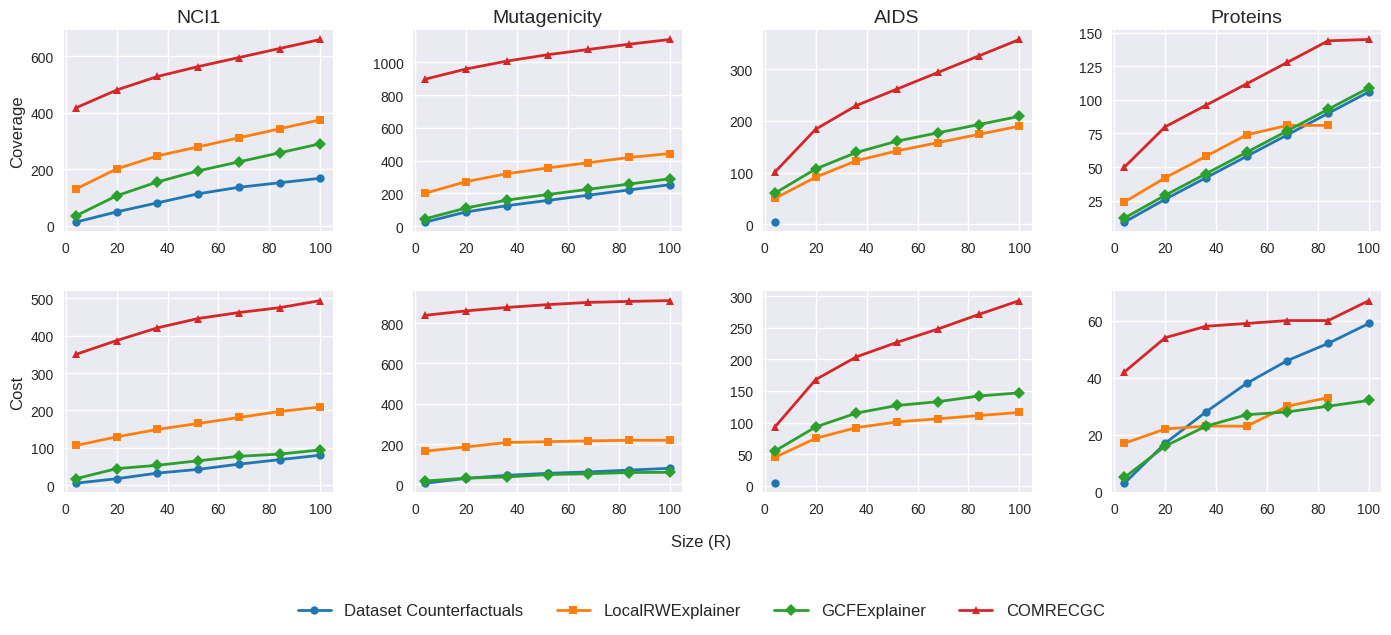

In [ ]:
X = np.arange(4,101,16)

# Use the seaborn style
plt.style.use('seaborn')

# Define a color palette
#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
colors = ['#1f77b4', '#d62728']

#markers = ['o', 's', 'D', '^']
markers = ['o', '^']



# Create the subplots
figure, axis = plt.subplots(2, 4, figsize=(17, 6))

# Set the y-axis labels
axis[0, 0].set_ylabel("Coverage", fontsize=12)
axis[1, 0].set_ylabel("Cost", fontsize=12)

# Define labels for legend
#labels = ['Dataset Counterfactuals', 'LocalRWExplainer', 'GCFExplainer', 'COMRECGC']
labels = ['Dataset Counterfactuals', 'COMRECGC']


# Function to plot data
def plot_data(ax, data, title):
    for i, (color, marker) in enumerate(zip(colors, markers)):
        if title == "Proteins" and i == 1:
            ax.plot(X[:-1], [data[i][0][j-1] for j in X[:-1]], marker=marker, color=color, label=labels[i], linewidth=2, markersize=6)
        elif title == "AIDS" and i == 0:
            ax.plot(X[:1], [data[i][0][j-1] for j in X[:1]], marker=marker, color=color, label=labels[i], linewidth=2, markersize=6)
        else:
            ax.plot(X, [data[i][0][j-1] for j in X], marker=marker, color=color, label=labels[i], linewidth=2, markersize=6)
    ax.set_title(title, fontsize=14)
    ax.grid(True)

# Plot data
plot_data(axis[0, 0], rez["nci1"], "NCI1")
plot_data(axis[0, 1], rez["mutagenicity"], "Mutagenicity")
plot_data(axis[0, 2], rez["aids"], "AIDS")
plot_data(axis[0, 3], rez["proteins"], "Proteins")

# Adjust the second row
for i, data_key in enumerate(["nci1", "mutagenicity", "aids", "proteins"]):
    for j, (color, marker) in enumerate(zip(colors, markers)):
        if data_key == "proteins" and j == 1:
            axis[1, i].plot(X[:-1], [rez[data_key][j][1][k-1] for k in X[:-1]], marker=marker, color=color, linewidth=2, markersize=6)
        elif data_key == "aids" and j == 0:
            axis[1, i].plot(X[:1], [rez[data_key][j][1][k-1] for k in X[:1]], marker=marker, color=color, linewidth=2, markersize=6)
        else:
            axis[1, i].plot(X, [rez[data_key][j][1][k-1] for k in X], marker=marker, color=color, linewidth=2, markersize=6)
    axis[1, i].grid(True)

# Add common legend
figure.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)

# Add common x-axis label
figure.text(0.5, 0.02, 'Size (R)', ha='center', fontsize=12)

# Adjust subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Save the figure as a PDF
plt.savefig('plot.pdf', format='pdf')

plt.show()
